In [1]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 2.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 6.3 MB/s eta 0:00:00


In [2]:
!pip install -U gdown

In [3]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, concatenate, LSTM, Reshape, Dense, Bidirectional, Attention, Permute, Multiply, Lambda, RepeatVector, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.layers import Softmax, MultiHeadAttention, LayerNormalization, Add
from keras.saving import register_keras_serializable
import tensorflow.keras.backend as K

import pandas_market_calendars as mcal

2025-05-25 16:42:56.232204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748191376.543262      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748191376.633375      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow as tf
import random

SEED = 2025

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  

In [5]:
print(tf.__version__)

2.18.0


In [6]:
def moving_average(x, k):
    return np.convolve(x, np.ones(k), 'valid') / k

def compute_mid_price_changes(daily_data_dict, date_list, k):
    all_changes = []
    for date in date_list:
        price_bid = daily_data_dict[date][:, 0]
        size_bid = daily_data_dict[date][:, 1]
        price_ask = daily_data_dict[date][:, 2]
        size_ask = daily_data_dict[date][:, 3]
        mid_price = (price_ask * size_bid + price_bid * size_ask) / (size_ask + size_bid)

        future_avg = moving_average(mid_price, k)[1:]  # Skip current step
        current = mid_price[:-k]
        pct_change = (future_avg - current) / current
        all_changes.extend(pct_change)
    return np.array(all_changes)

In [7]:
import gdown

file_id = "1Awq8DwZovxzNuSSg2xGOKE56ZKYaqjKw"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="combined_orderbooks_eth_large.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Awq8DwZovxzNuSSg2xGOKE56ZKYaqjKw
From (redirected): https://drive.google.com/uc?id=1Awq8DwZovxzNuSSg2xGOKE56ZKYaqjKw&confirm=t&uuid=4c3f02c4-7467-40e0-ad10-4982834d2601
To: /kaggle/working/combined_orderbooks_eth_large.csv
100%|██████████| 234M/234M [00:02<00:00, 107MB/s]  


'combined_orderbooks_eth_large.csv'

In [8]:
df = pd.read_csv("combined_orderbooks_eth_large.csv")

In [9]:
df

,timestamp,bid_price_1,bid_size_1,ask_price_1,ask_size_1,bid_price_2,bid_size_2,ask_price_2,ask_size_2,bid_price_3,...,ask_price_8,ask_size_8,bid_price_9,bid_size_9,ask_price_9,ask_size_9,bid_price_10,bid_size_10,ask_price_10,ask_size_10
0,1745798400,1790.31,38.59,1790.32,15.04,1790.30,0.68,1790.34,0.08,1790.28,...,1790.43,0.02,1790.21,0.02,1790.45,0.04,1790.20,1.12,1790.47,0.02
1,1745798401,1790.31,38.71,1790.32,14.93,1790.30,0.68,1790.34,0.08,1790.28,...,1790.43,0.02,1790.21,0.02,1790.45,0.04,1790.20,1.12,1790.47,0.02
2,1745798402,1790.31,18.98,1790.32,27.39,1790.28,0.02,1790.33,0.03,1790.26,...,1790.41,1.00,1790.20,1.12,1790.43,0.02,1790.19,0.16,1790.45,0.02
3,1745798403,1790.31,27.70,1790.32,9.89,1790.28,0.02,1790.34,0.08,1790.26,...,1790.43,0.02,1790.20,1.12,1790.45,0.02,1790.19,0.16,1790.47,0.02
4,1745798404,1790.31,27.58,1790.32,10.34,1790.28,0.02,1790.34,0.08,1790.26,...,1790.43,0.02,1790.20,1.12,1790.45,0.02,1790.19,0.16,1790.47,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863996,1746662396,1810.48,52.96,1810.49,62.14,1810.47,1.53,1810.50,0.01,1810.45,...,1810.58,5.06,1810.36,0.02,1810.59,16.34,1810.35,6.29,1810.60,1.97
863997,1746662397,1810.48,6.68,1810.49,74.63,1810.47,0.02,1810.50,0.01,1810.45,...,1810.59,16.34,1810.36,0.02,1810.60,1.97,1810.35,6.29,1810.61,0.03
863998,1746662398,1810.48,19.02,1810.49,55.80,1810.46,0.02,1810.50,0.01,1810.45,...,1810.59,16.34,1810.36,8.30,1810.60,1.97,1810.35,6.29,1810.61,0.03
863999,1746662399,1810.26,4.74,1810.27,93.51,1810.25,0.02,1810.30,2.95,1810.24,...,1810.38,0.01,1810.13,3.87,1810.40,1.97,1810.12,0.17,1810.41,0.30


In [10]:
df = df.sort_values(by=['timestamp']).reset_index(drop=True)

In [11]:
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['date'].dt.date
df['date'] = df['date'].apply(lambda x: str(x))

In [12]:
df = df[df['date'] != '2025-05-08'].reset_index(drop=True)

In [13]:
numeric_columns = [col for col in df.columns if col not in ['timestamp', 'date']]

In [14]:
dates_str_list = list(df['date'].unique())

In [15]:
daily_data_dict = {}

In [16]:
for i in range(len(dates_str_list)):
    date = dates_str_list[i]
    if date not in daily_data_dict.keys():
        daily_data_dict[date] = np.array(df[df['date']==dates_str_list[i]][numeric_columns])

In [17]:
mid_price_changes = compute_mid_price_changes(daily_data_dict, ['2025-04-28'], 8)

In [18]:
alpha = np.quantile(mid_price_changes, 0.3)

In [19]:
alpha

-6.495761631192181e-05

In [20]:
daily_data_dict.pop('2025-04-28')

array([[1.79031e+03, 3.85900e+01, 1.79032e+03, ..., 1.12000e+00,
        1.79047e+03, 2.00000e-02],
       [1.79031e+03, 3.87100e+01, 1.79032e+03, ..., 1.12000e+00,
        1.79047e+03, 2.00000e-02],
       [1.79031e+03, 1.89800e+01, 1.79032e+03, ..., 1.60000e-01,
        1.79045e+03, 2.00000e-02],
       ...,
       [1.79890e+03, 1.36890e+02, 1.79891e+03, ..., 2.00000e-02,
        1.79901e+03, 2.00000e-02],
       [1.79890e+03, 1.39910e+02, 1.79891e+03, ..., 2.00000e-02,
        1.79901e+03, 2.00000e-02],
       [1.79890e+03, 1.38780e+02, 1.79891e+03, ..., 2.00000e-02,
        1.79901e+03, 2.00000e-02]])

In [21]:
dates_str_list = dates_str_list[1:]

In [22]:
normalization_mean_dict = {}
normalization_stddev_dict = {}

In [23]:
for i in range(5,len(dates_str_list)):
    date = dates_str_list[i]

    if (date not in normalization_mean_dict.keys()) or (date not in normalization_stddev_dict.keys()):
        look_back_dates_list = dates_str_list[(i-5):i]
        prev_5_day_orderbook_np = None
        for look_back_date in look_back_dates_list:
            if prev_5_day_orderbook_np is None:
                prev_5_day_orderbook_np = daily_data_dict[look_back_date]
            else:
                prev_5_day_orderbook_np = np.vstack((prev_5_day_orderbook_np, daily_data_dict[look_back_date]))


        price_mean = prev_5_day_orderbook_np[:,range(0,prev_5_day_orderbook_np.shape[1],2)].mean()
        price_std = prev_5_day_orderbook_np[:,range(0,prev_5_day_orderbook_np.shape[1],2)].std()
        size_mean = prev_5_day_orderbook_np[:,range(1,prev_5_day_orderbook_np.shape[1],2)].mean()
        size_std = prev_5_day_orderbook_np[:,range(1,prev_5_day_orderbook_np.shape[1],2)].std()

        normalization_mean_dict[date] = np.repeat([[price_mean,size_mean]], 20, axis=0).flatten()
        normalization_stddev_dict[date] = np.repeat([[price_std,size_std]], 20, axis=0).flatten()

In [24]:
daily_norm_data_dict = {}

In [25]:
daily_norm_data_dict = {}
for i in range(5, len(dates_str_list)):
    date = dates_str_list[i]
    if date not in daily_norm_data_dict.keys():
        raw_data = daily_data_dict[date]

        # Шаг 1: Нормализация базовых 40 признаков
        norm_data = (raw_data - normalization_mean_dict[date]) / normalization_stddev_dict[date]

        # Шаг 2: Feature engineering — доп. признаки

        # Mid-price = (ask_price_1 + bid_price_1) / 2
        mid_price = ((raw_data[:, 2] + raw_data[:, 0]) / 2).reshape(-1, 1)

        # Spread = ask_price_1 - bid_price_1
        spread = (raw_data[:, 2] - raw_data[:, 0]).reshape(-1, 1)

        # Imbalance = (bid_depth - ask_depth) / (bid_depth + ask_depth)
        bid_depth = raw_data[:, [i for i in range(1, 40, 4)]].sum(axis=1)
        ask_depth = raw_data[:, [i for i in range(3, 40, 4)]].sum(axis=1)
        imbalance = ((bid_depth - ask_depth) / (bid_depth + ask_depth + 1e-8)).reshape(-1, 1)

        # Объединяем все признаки в один массив
        full_data = np.hstack([norm_data, mid_price, spread, imbalance])

        daily_norm_data_dict[date] = full_data

In [26]:
list(daily_data_dict.keys())[5:]

['2025-05-04', '2025-05-05', '2025-05-06', '2025-05-07']

In [27]:
def generate_labels(k, alpha, daily_data_dict):
    daily_label_dict = {}
    for date in list(daily_data_dict.keys())[5:]:
        price_bid = daily_data_dict[date][:,0]
        size_bid = daily_data_dict[date][:,1]
        price_ask = daily_data_dict[date][:,2]
        size_ask = daily_data_dict[date][:,3]
        mid_price = (price_ask * size_bid + price_bid * size_ask) / (size_ask + size_bid)
        future_k_avg_mid_price = moving_average(mid_price, k)[1:]
        print(future_k_avg_mid_price.shape, mid_price[:-k].shape)
        change_pct = (future_k_avg_mid_price - mid_price[:-k])/mid_price[:-k]
        print(change_pct, len(change_pct))
        y_label = (-(change_pct < -alpha).astype(int)) + (change_pct > alpha).astype(int)

        daily_label_dict[date] = y_label.reshape(-1,1)
    return daily_label_dict

In [28]:
def generate_X_y(k, alpha, timestamp_per_sample, daily_norm_data_dict, daily_data_dict):
    #k is the number of future timesteps used to generate the label y
    data_x = None
    for date in daily_norm_data_dict.keys():
        if data_x is None:
            data_x = daily_norm_data_dict[date].copy()[:-k,:]
        else:
            data_x = np.vstack((data_x, daily_norm_data_dict[date][:-k,:]))

    daily_label_dict = generate_labels(k, alpha, daily_data_dict)
    data_y = None
    for date in daily_label_dict.keys():
        if data_y is None:
            data_y = daily_label_dict[date].copy()
        else:
            data_y = np.vstack((data_y, daily_label_dict[date]))

    [N, P_x] = data_x.shape

    x = np.zeros([(N-timestamp_per_sample+1), timestamp_per_sample, P_x])

    for i in range(N-timestamp_per_sample+1):
        x[i] = data_x[i:(i+timestamp_per_sample), :]

    x = x.reshape(x.shape + (1,))
    y = data_y[(timestamp_per_sample-1):]
    y = to_categorical(y, 3)

    return x, y

In [29]:
daily_norm_data_dict.pop('2025-05-07')
daily_data_dict.pop('2025-05-07')

array([[1.81636e+03, 5.87400e+01, 1.81637e+03, ..., 4.00000e-02,
        1.81650e+03, 1.97400e+01],
       [1.81679e+03, 1.34600e+01, 1.81680e+03, ..., 4.60000e-01,
        1.81692e+03, 3.36000e+00],
       [1.81681e+03, 2.49000e+00, 1.81682e+03, ..., 2.00000e-02,
        1.81693e+03, 3.40000e-01],
       ...,
       [1.81048e+03, 6.68000e+00, 1.81049e+03, ..., 6.29000e+00,
        1.81061e+03, 3.00000e-02],
       [1.81048e+03, 1.90200e+01, 1.81049e+03, ..., 6.29000e+00,
        1.81061e+03, 3.00000e-02],
       [1.81026e+03, 4.74000e+00, 1.81027e+03, ..., 1.70000e-01,
        1.81041e+03, 3.00000e-01]])

In [30]:
X,y = generate_X_y(k=8, alpha=alpha, timestamp_per_sample=100,
                   daily_norm_data_dict= daily_norm_data_dict,
                   daily_data_dict = daily_data_dict)

(86392,) (86392,)
[ 5.57455492e-05  1.01256770e-05  1.72004573e-05 ... -4.25251081e-05
 -4.80992974e-05 -5.47959905e-05] 86392
(86392,) (86392,)
[-1.89716698e-04 -2.51378867e-04 -3.24225802e-04 ...  3.04242716e-05
 -5.76103946e-08  1.98654638e-06] 86392
(86392,) (86392,)
[ 1.94291057e-04 -1.46386669e-06 -2.07872586e-05 ...  6.15573640e-05
  8.43943060e-05  1.04291292e-04] 86392


In [31]:
del daily_norm_data_dict
del daily_data_dict
del dates_str_list
del normalization_mean_dict
del normalization_stddev_dict
del df
import gc; gc.collect()

64

In [32]:
y[:, 0].sum(), y[:, 1].sum(), y[:, 2].sum()

(137151.0, 61099.0, 60827.0)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    shuffle=False
)

In [34]:
lookback_timestep = 100
feature_num = 43

#Conv param
conv_filter_num = 16

#Inception module param
inception_num = 32

#LSTM param
LSTM_num = 64

#Activation param
leaky_relu_alpha = 0.01

# ADAM is used
learning_rate = 1e-3
adam_epsilon = 1e-7
optimizer = Adam(learning_rate=learning_rate, epsilon=adam_epsilon)

# accuracy is used for stopping training
metrics = ['accuracy']

num_epoch = 100
#stop training when validation accuracy does not improve for 20 epochs
stop_epoch_num = 50

batch_size = 256

I0000 00:00:1747984045.223134      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747984045.223781      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [50]:
@register_keras_serializable()
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-8, 1. - 1e-8)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=1))
    return loss

In [36]:
def initiate_DeepLOB_modified_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                        optimizer, metrics):

    input_tensor = Input(shape=(lookback_timestep, feature_num, 1))
    print("Input tensor shape:", input_tensor.shape)

    # --- Conv Block 1 ---
    conv_layer1 = Conv2D(conv_filter_num, (1, 2), strides=(1, 2))(input_tensor)
    print("Conv1-1 (1x2) shape:", conv_layer1.shape)

    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print("Conv1-1 after LeakyReLU:", conv_layer1.shape)

    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    print("Conv1-2 (4x1) shape:", conv_layer1.shape)

    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)

    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    print("Conv1-3 (4x1) shape:", conv_layer1.shape)

    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)

    # --- Conv Block 2 ---
    conv_layer2 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(conv_layer1)
    print("Conv2-1 (1x2) shape:", conv_layer2.shape)

    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)

    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    print("Conv2-2 (4x1) shape:", conv_layer2.shape)

    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)

    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    print("Conv2-3 (4x1) shape:", conv_layer2.shape)

    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)

    # --- Conv Block 3 ---
    conv_layer3 = Conv2D(conv_filter_num, (1,10))(conv_layer2)
    print("Conv3-1 (1x10) shape:", conv_layer3.shape)

    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)

    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    print("Conv3-2 (4x1) shape:", conv_layer3.shape)

    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)

    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    print("Conv3-3 (4x1) shape:", conv_layer3.shape)

    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)

    # --- Inception Module ---
    inception_module1 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    print("Inception branch 1 - after 1x1 LeakyReLU:", inception_module1.shape)

    inception_module1 = Conv2D(inception_num, (3,1), padding='same')(inception_module1)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    print("Inception branch 1 - after 3x1:", inception_module1.shape)

    inception_module2 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    print("Inception branch 2 - after 1x1 LeakyReLU:", inception_module2.shape)

    inception_module2 = Conv2D(inception_num, (5,1), padding='same')(inception_module2)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    print("Inception branch 2 - after 5x1:", inception_module2.shape)

    inception_module3 = MaxPooling2D((3,1), strides=(1,1), padding='same')(conv_layer3)
    print("Inception branch 3 - after MaxPooling:", inception_module3.shape)

    inception_module3 = Conv2D(inception_num, (1,1), padding='same')(inception_module3)
    print("Inception branch 3 - after 1x1 conv:", inception_module3.shape)

    inception_module3 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module3)
    print("Inception branch 3 - after LeakyReLU:", inception_module3.shape)

    # Объединяем
    inception_module_final = concatenate([inception_module1, inception_module2, inception_module3], axis=3)
    print("After concatenation:", inception_module_final.shape)

    # Преобразуем для LSTM или Attention
    inception_module_final = Reshape((inception_module_final.shape[1], inception_module_final.shape[3]))(inception_module_final)
    print("After reshape:", inception_module_final.shape)

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(LSTM_num, return_sequences=True))(inception_module_final)
    print("Bidirectional LSTM:", lstm_out.shape)

    # Attention слой (self-attention по временной оси)
    attention_scores = Dense(1, activation='tanh')(lstm_out)
    attention_weights = Softmax(axis=1)(attention_scores)
    print("Attention weights:", attention_weights.shape)
    @register_keras_serializable()
    def attention_context(x):
        return tf.reduce_sum(x[0] * x[1], axis=1)
    
    @register_keras_serializable()
    def attention_output_shape(input_shapes):
        return (input_shapes[0][0], input_shapes[0][2])
    
    context = Lambda(attention_context, output_shape=attention_output_shape)([lstm_out, attention_weights])

    print("Context vector:", context.shape)

    # Fully Connected Layer with softmax activation function for output
    model_output = Dense(3, activation='softmax')(context)
    print(model_output.shape)

    DeepLOB_modified_model = Model(inputs=input_tensor, outputs= model_output)
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

    DeepLOB_modified_model.compile(optimizer=optimizer, loss=focal_loss(), metrics=metrics)

    return DeepLOB_modified_model

In [37]:
DeepLOB_modified_model = initiate_DeepLOB_modified_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                             optimizer, metrics)

Input tensor shape: (None, 100, 43, 1)
Conv1-1 (1x2) shape: (None, 100, 21, 16)
Conv1-1 after LeakyReLU: (None, 100, 21, 16)
Conv1-2 (4x1) shape: (None, 100, 21, 16)
Conv1-3 (4x1) shape: (None, 100, 21, 16)
Conv2-1 (1x2) shape: (None, 100, 10, 16)
Conv2-2 (4x1) shape: (None, 100, 10, 16)
Conv2-3 (4x1) shape: (None, 100, 10, 16)
Conv3-1 (1x10) shape: (None, 100, 1, 16)
Conv3-2 (4x1) shape: (None, 100, 1, 16)
Conv3-3 (4x1) shape: (None, 100, 1, 16)
Inception branch 1 - after 1x1 LeakyReLU: (None, 100, 1, 32)
Inception branch 1 - after 3x1: (None, 100, 1, 32)
Inception branch 2 - after 1x1 LeakyReLU: (None, 100, 1, 32)
Inception branch 2 - after 5x1: (None, 100, 1, 32)
Inception branch 3 - after MaxPooling: (None, 100, 1, 16)
Inception branch 3 - after 1x1 conv: (None, 100, 1, 32)
Inception branch 3 - after LeakyReLU: (None, 100, 1, 32)
After concatenation: (None, 100, 1, 96)
After reshape: (None, 100, 96)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Bidirectional LSTM: (None, 100, 128)
Attention weights: (None, 100, 1)
Context vector: (None, 128)
(None, 3)


In [38]:
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [39]:
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  
checkpoint_path = os.path.join(checkpoint_dir, 'best_model_v4.keras')


model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=stop_epoch_num,
    restore_best_weights=True,
    verbose=1
)

csv_logger = CSVLogger('training_log.csv')

In [40]:
DeepLOB_modified_model.fit(
    X_train, y_train,
    epochs=num_epoch,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint, csv_logger],
    class_weight=class_weight_dict,
    verbose=2
)

Epoch 1/100


2025-05-23 07:07:44.304427: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
I0000 00:00:1747984073.313524     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-23 07:09:06.906033: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:var


Epoch 1: val_accuracy improved from -inf to 0.53530, saving model to checkpoints/best_model_v4.keras
810/810 - 91s - 112ms/step - accuracy: 0.5293 - loss: 0.1101 - val_accuracy: 0.5353 - val_loss: 0.1079
Epoch 2/100

Epoch 2: val_accuracy improved from 0.53530 to 0.54051, saving model to checkpoints/best_model_v4.keras
810/810 - 76s - 94ms/step - accuracy: 0.5363 - loss: 0.1076 - val_accuracy: 0.5405 - val_loss: 0.1069
Epoch 3/100

Epoch 3: val_accuracy improved from 0.54051 to 0.54089, saving model to checkpoints/best_model_v4.keras
810/810 - 77s - 95ms/step - accuracy: 0.5391 - loss: 0.1070 - val_accuracy: 0.5409 - val_loss: 0.1061
Epoch 4/100

Epoch 4: val_accuracy improved from 0.54089 to 0.54796, saving model to checkpoints/best_model_v4.keras
810/810 - 77s - 96ms/step - accuracy: 0.5474 - loss: 0.1020 - val_accuracy: 0.5480 - val_loss: 0.1007
Epoch 5/100

Epoch 5: val_accuracy improved from 0.54796 to 0.55218, saving model to checkpoints/best_model_v4.keras
810/810 - 77s - 95ms/

In [41]:
import shutil

# 1. Zip the entire checkpoints folder
shutil.make_archive('/kaggle/working/checkpoints_backup_v3', 'zip', '/kaggle/working/checkpoints')

'/kaggle/working/checkpoints_backup_v3.zip'

In [35]:
@register_keras_serializable()
def attention_context(x):
    return tf.reduce_sum(x[0] * x[1], axis=1)

@register_keras_serializable()
def attention_output_shape(input_shapes):
    return (input_shapes[0][0], input_shapes[0][2])

@register_keras_serializable(name="loss")
def focal_loss_wrapper(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1. - 1e-8)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss

In [58]:
from keras.models import load_model

model = load_model(
    'checkpoints/best_model_v4.keras',
    custom_objects={
        'loss': focal_loss_wrapper(),
        'attention_context': attention_context,
        'attention_output_shape': attention_output_shape
    }
)

In [36]:
from keras.models import load_model

model = load_model(
    '/kaggle/input/best_model_v4.keras/keras/default/1/best_model_v4.keras',
    custom_objects={
        'loss': focal_loss_wrapper(),
        'attention_context': attention_context,
        'attention_output_shape': attention_output_shape
    }
)

2025-05-25 16:47:09.562386: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [37]:
from sklearn.metrics import classification_report
import numpy as np

# Предсказания
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Отчёт по классам
print(classification_report(y_true, y_pred, target_names=['Down', 'Neutral', 'Up'], digits=4))

2025-05-25 16:47:15.898142: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step
              precision    recall  f1-score   support

        Down     0.6997    0.7361    0.7174     27485
     Neutral     0.6438    0.5147    0.5720     12214
          Up     0.5904    0.6399    0.6142     12117

    accuracy                         0.6614     51816
   macro avg     0.6446    0.6302    0.6345     51816
weighted avg     0.6609    0.6614    0.6590     51816



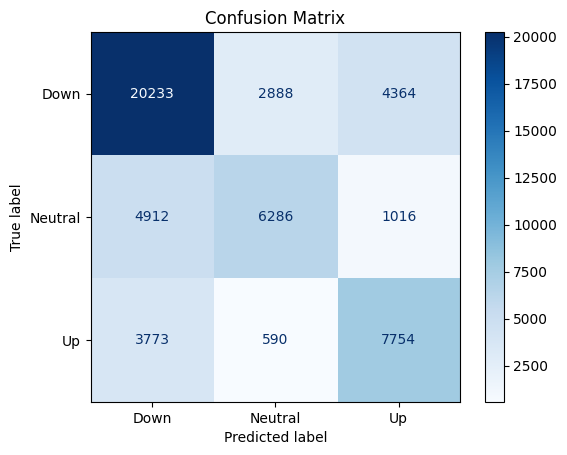

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Neutral', 'Up'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()